In [4]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np

from redbaron import redbaron
redbaron.ipython_behavior = False

# import os
# import sys
# sys.path.insert(0, os.path.abspath('/home/gaspar/git/pyha'))

## Modulated signal
Lets use previously developed FSK modulator component to first synthesize a testing signal.

<IPython.core.display.Javascript object>


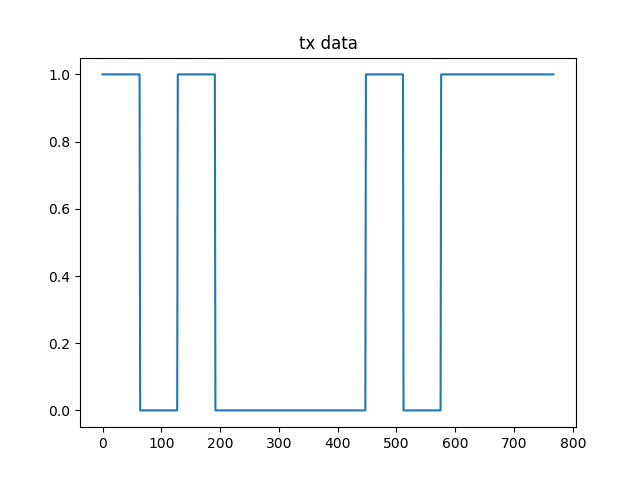

/home/gaspar/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


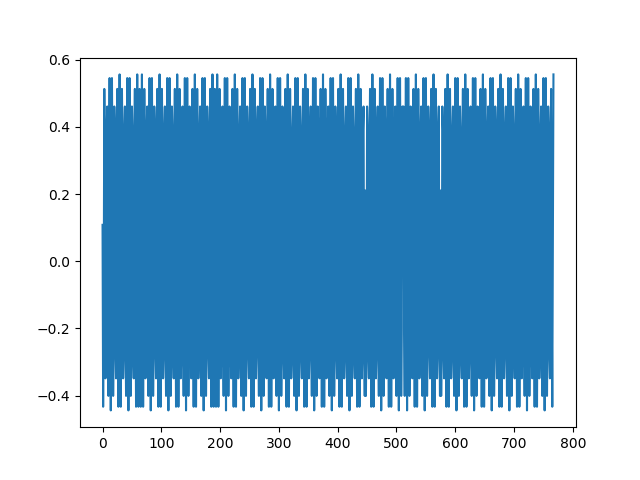

<IPython.core.display.Javascript object>


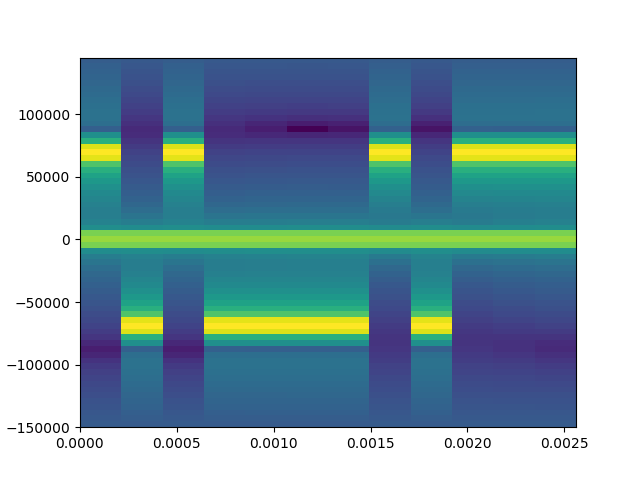

In [18]:
from pyhacores.under_construction.fsk_modulator.model import FSKModulator
samples_per_symbol = 64 # this is so high to make stuff plottable
symbols = [1, 0, 1, 0, 0, 0, 0, 1, 0 ,1, 1, 1 ]

data = []
for x in symbols:
    data.extend([x] * samples_per_symbol)
    
plt.plot(data)
plt.title('tx data')
plt.show()

fs = 300e3
deviation = 70e3
mod = FSKModulator(deviation, fs)

tx_signal = mod.model_main(data)

# awgn channel (add some noise)
tx_signal = (tx_signal + np.random.normal(scale=np.sqrt(0.25))) * 0.5

plt.plot(tx_signal)
plt.show()

Pxx, freqs, bins, im = plt.specgram(tx_signal, Fs=fs, NFFT=64, noverlap=0)
# plt.ylim([-15000, 15000])
plt.show()

## Demodulator

We use quadrature demodulator to turn RF back to data. Result is noisy, because we added quite a bit of noise to the TX signal.

INFO:pyha.simulation.simulation_interface:Running MODEL simulation!
INFO:pyha.simulation.simulation_interface:Running HW_MODEL simulation!
INFO:pyha.simulation.simulation_interface:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:pyha.simulation.simulation_interface:Running RTL simulation!
INFO:pyha.simulation.simulation_interface:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:pyha.simulation.cocotb:Running COCOTB simulation....


<IPython.core.display.Javascript object>


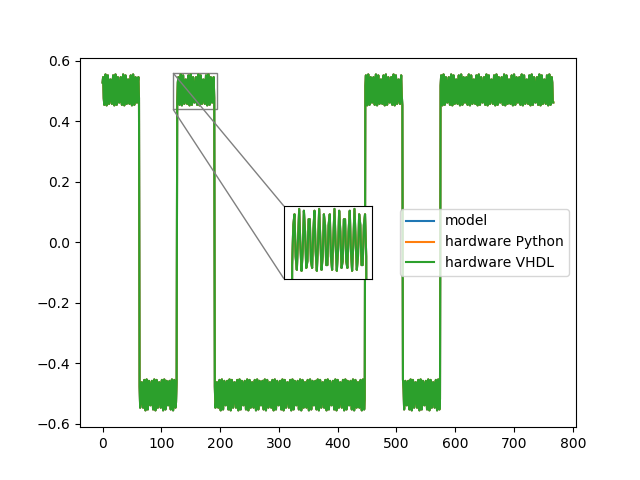

In [72]:
gain = fs / (2 * np.pi * deviation) / 2

from pyhacores.under_construction.quadrature_demodulator.model import QuadratureDemodulator
from pyha.simulation.simulation_interface import assert_sim_match, SIM_MODEL, SIM_HW_MODEL, \
    SIM_RTL, plot_assert_sim_match, debug_assert_sim_match

qd = QuadratureDemodulator(gain)
demod = qd.model_main(tx_signal)

r = debug_assert_sim_match(qd, None, tx_signal, simulations=[SIM_MODEL, SIM_HW_MODEL, SIM_RTL])

# plt.plot(rx_demod)
# # plt.plot(data)
# plt.show()

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(r[0], label='model')
ax.plot(r[1], label='hardware Python')
ax.plot(r[2], label='hardware VHDL')
ax.legend()


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax, 2, loc=10) # zoom-factor: 2.5, location: upper-left
axins.plot(r[0])
axins.plot(r[1])
axins.plot(r[2])


x1, x2, y1, y2 = 120, 195, 0.44, 0.56 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)


from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

plt.show()

# Matched filtering
Noise situation can be improved by using matched filtering.

In [62]:
from pyhacores.moving_average.model import MovingAverage
mf = MovingAverage(window_len=samples_per_symbol)

rx_matched = mf.model_main(rx_demod)

plt.plot(rx_matched)
plt.show()

NameError: name 'rx_demod' is not defined

# Timing recovery
Next step is to figure out correct time instances when to sample for a bit. Will be using M&M clock recovery for the job.
TODO